In [1]:
# Training script for LazyConfig models
try:
    # ignore ShapelyDeprecationWarning from fvcore
    import warnings

    from shapely.errors import ShapelyDeprecationWarning

    warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

except:
    pass
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger

setup_logger()

import gc
import os
import time

import detectron2.utils.comm as comm

# import some common libraries
import numpy as np
import torch

# import some common detectron2 utilities
from detectron2.config import LazyConfig, get_cfg
from detectron2.engine import (
    launch,
)

from deepdisc.data_format.augment_image import train_augs
from deepdisc.data_format.image_readers import DC2ImageReader
from deepdisc.data_format.register_data import register_data_set
from deepdisc.model.loaders import (
    RedshiftFlatDictMapper,
    return_test_loader,
    return_train_loader,
)
from deepdisc.model.models import RedshiftPointCasROIHeads, RedshiftPointROIHeads, RedshiftPDFROIHeads, return_lazy_model
from deepdisc.training.trainers import (
    return_evallosshook,
    return_lazy_trainer,
    return_optimizer,
    return_savehook,
    return_schedulerhook,
)
from deepdisc.utils.parse_arguments import make_training_arg_parser

import detectron2.solver as solver

import matplotlib.pyplot as plt

In [2]:
cfgfile = "/home/shared/hsc/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.py"
dirpath = './tests/deepdisc/test_data/'
output_dir = './'
output_name = 'test'

trainfile = dirpath + "flattened_data_test.npy"
testfile = dirpath + "flattened_data_test.npy"


In [3]:
classes = ['object']
numclasses = 1

testdata = np.load('./tests/deepdisc/test_data/flattened_data_test.npy')


mapper = RedshiftFlatDictMapper().map_data
dataset_dicts={}
dds = []
for row in testdata:
    dds.append(mapper(row))
dataset_dicts['test'] = dds


In [4]:
astrotrain_metadata = register_data_set("astro_train", trainfile, np.load, thing_classes=classes)
astroval_metadata = register_data_set("astro_val", testfile, np.load, thing_classes=classes)

In [5]:
cfg = LazyConfig.load(cfgfile)

# metadata = MetadataCatalog.get(cfg.dataloader.test.dataset.names) # to get labels from ids

bs = 1
cfg.model.proposal_generator.anchor_generator.sizes = [[8], [16], [32], [64], [128]]
cfg.model.proposal_generator.batch_size_per_image = 512

cfg.dataloader.train.total_batch_size = bs
cfg.model.roi_heads.num_classes = numclasses
cfg.model.roi_heads.batch_size_per_image = 128
#cfg.model.backbone.bottom_up.in_chans = 6
cfg.model.backbone.bottom_up.stem.in_channels = 6
#cfg.model.pixel_mean = [0.00376413, 0.01292477, 0.04308919, 0.08965224, 0.13665777, 0.16544563]
#cfg.model.pixel_std =[0.07028706, 0.06942783, 0.2432113, 0.55617297, 0.8046262, 0.9044935]
cfg.model.pixel_mean = [0.00604957, 0.0097893, 0.02428164, 0.04782381, 0.06689043, 0.07634047]
cfg.model.pixel_std = [0.07637636, 0.07277052, 0.19012378, 0.42937884, 0.5813913, 0.65684605]

cfg.model.roi_heads._target_ = RedshiftPointROIHeads
#cfg.model.roi_heads._target_ = RedshiftPDFROIHeads
#cfg.model.roi_heads.num_components = 1

cfg_loader = get_cfg()
cfg_loader.SOLVER.IMS_PER_BATCH = bs
cfg_loader.DATASETS.TRAIN = "astro_train"  # Register Metadata
cfg_loader.DATASETS.TEST = "astro_val"
# cfg_loader.DATALOADER.NUM_WORKERS = 0
#cfg_loader.DATALOADER.PREFETCH_FACTOR = 2
cfg_loader.SOLVER.BASE_LR = 0.001
cfg_loader.OUTPUT_DIR = output_dir
os.makedirs(cfg_loader.OUTPUT_DIR, exist_ok=True)

cfg_loader.SOLVER.CLIP_GRADIENTS.ENABLED = True
# Type of gradient clipping, currently 2 values are supported:
# - "value": the absolute values of elements of each gradients are clipped
# - "norm": the norm of the gradient for each parameter is clipped thus
#   affecting all elements in the parameter
cfg_loader.SOLVER.CLIP_GRADIENTS.CLIP_TYPE = "norm"
# Maximum absolute value used for clipping gradients
# Floating point number p for L-p norm to be used with the "norm"
# gradient clipping type; for L-inf, please specify .inf
cfg_loader.SOLVER.CLIP_GRADIENTS.NORM_TYPE = 5.0

# iterations for 15,25,35,50 epochs
epoch = int(len(dataset_dicts['test']) / cfg.dataloader.train.total_batch_size)
e1 = 4000

val_per = 100


In [6]:
model = return_lazy_model(cfg)

cfg.optimizer.params.model = model
cfg.optimizer.lr = 0.001

cfg_loader.SOLVER.STEPS = []  # do not decay learning rate for retraining
cfg_loader.SOLVER.LR_SCHEDULER_NAME = "WarmupMultiStepLR"
cfg_loader.SOLVER.WARMUP_ITERS = 0
cfg_loader.SOLVER.MAX_ITER = e1  # for DefaultTrainer

# optimizer = instantiate(cfg.optimizer)

#optimizer = return_optimizer(cfg)

optimizer = solver.build_optimizer(cfg_loader, model)


mapper = RedshiftFlatDictMapper().map_data
loader = return_train_loader(cfg_loader, mapper)
test_loader = return_test_loader(cfg_loader, mapper)

saveHook = return_savehook(output_name)
lossHook = return_evallosshook(val_per, model, test_loader)
schedulerHook = return_schedulerhook(optimizer)
hookList = [lossHook, schedulerHook, saveHook]

trainer = return_lazy_trainer(model, loader, optimizer, cfg, cfg_loader, hookList)

trainer.set_period(100)
trainer.train(0, e1)

np.save(output_dir + output_name + "_losses", trainer.lossList)
np.save(output_dir + output_name + "_val_losses", trainer.vallossList)

[11/10 15:24:37 d2.data.build]: Using training sampler TrainingSampler
[11/10 15:24:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/10 15:24:37 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[11/10 15:24:37 d2.data.common]: Serialized dataset takes 7.50 MiB
[11/10 15:24:37 d2.data.build]: Making batched data loader with batch_size=1
[11/10 15:24:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/10 15:24:37 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[11/10 15:24:37 d2.data.common]: Serialized dataset takes 7.50 MiB
[11/10 15:24:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from detectron2://ImageNetPretrained/MSRA/R-50.pkl ...
[11/10 15:24:37 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
WARNING [11/10 15:24:37 d2.checkpoint.c2_model_loading

/home/g4merz/detectron2/detectron2/data/build.py:276: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  has_instances = "annotations" in dataset_dicts[0]
Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.stem.conv1.weight
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias,

[11/10 15:24:37 d2.engine.train_loop]: Starting training from iteration 0
Iteration:  100  time:  8.922070264816284e-07 dict_keys(['loss_cls', 'loss_box_reg', 'redshift_loss', 'loss_rpn_cls', 'loss_rpn_loc']) [0.07366456091403961, 0.06739430129528046, 0.0976154138090774, 0.010818175971508026, 0.00025211606407538056] val loss:  0 lr:  [0.001]
Iteration:  200  time:  6.07222318649292e-07 dict_keys(['loss_cls', 'loss_box_reg', 'redshift_loss', 'loss_rpn_cls', 'loss_rpn_loc']) [0.008967316709458828, 0.024839865043759346, 0.12012737132379689, 0.0049794940277934074, 7.3672053986229e-05] val loss:  0.27293488131358146 lr:  [0.001]
Iteration:  300  time:  6.016343832015991e-07 dict_keys(['loss_cls', 'loss_box_reg', 'redshift_loss', 'loss_rpn_cls', 'loss_rpn_loc']) [0.0009080680320039392, 0.003957063890993595, 0.005170288670700791, 0.004313685465604067, 3.2244679459836334e-05] val loss:  0.04461832401366914 lr:  [0.001]
Iteration:  400  time:  4.1909515857696533e-07 dict_keys(['loss_cls', 'loss

### Inference

In [7]:
from detectron2.config import LazyConfig
from deepdisc.model.models import  RedshiftPointCasROIHeads, RedshiftPointROIHeads, RedshiftPDFROIHeads, return_lazy_model
from deepdisc.inference.predictors import return_predictor_transformer

roi_thresh = 0.4
output_dir = './'

cfgfile = "/home/shared/hsc/detectron2/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.py"

cfg = LazyConfig.load(cfgfile)

#metadata = MetadataCatalog.get(cfg.dataloader.test.dataset.names)  # to get labels from ids
#classes = metadata.thing_classes

cfg.model.proposal_generator.anchor_generator.sizes = [[8], [16], [32], [64], [128]]
cfg.model.proposal_generator.batch_size_per_image = 512

#cfg.dataloader.train.total_batch_size = 4
cfg.model.roi_heads.num_classes = 1
cfg.model.roi_heads.batch_size_per_image = 128
cfg.model.backbone.bottom_up.stem.in_channels = 6
cfg.model.pixel_mean = [0.00604957, 0.0097893, 0.02428164, 0.04782381, 0.06689043, 0.07634047]
cfg.model.pixel_std = [0.07637636, 0.07277052, 0.19012378, 0.42937884, 0.5813913, 0.65684605]
#cfg.model.roi_heads.num_components = 1
#cfg.model.roi_heads._target_ = RedshiftPDFROIHeads
cfg.model.roi_heads._target_ = RedshiftPointROIHeads

cfg.model.roi_heads.box_predictor.test_score_thresh = roi_thresh
#for bp in cfg.model.roi_heads.box_predictors:
#    bp.test_score_thresh = roi_thresh
#cfg.model.proposal_generator.pre_nms_topk = [6000, 6000]
#cfg.model.proposal_generator.post_nms_topk = [6000, 6000]
cfg.model.proposal_generator.nms_thresh = 0.3

#for box_predictor in cfg.model.roi_heads.box_predictors:
#    #box_predictor.test_topk_per_image = 1000
#    box_predictor.test_score_thresh = roi_thresh

cfg_loader = get_cfg()
cfg_loader.SOLVER.IMS_PER_BATCH = 4
cfg_loader.DATASETS.TRAIN = "astro_test"  # Register Metadata
cfg_loader.DATASETS.TEST = "astro_test"
cfg_loader.DATALOADER.NUM_WORKERS = 1
cfg_loader.SOLVER.BASE_LR = 0.001
cfg_loader.OUTPUT_DIR = output_dir

cfg_loader.TEST.DETECTIONS_PER_IMAGE = 128

cfg_loader.OUTPUT_DIR = output_dir

cfg.train.init_checkpoint = os.path.join('./test.pth')

predictor = return_predictor_transformer(cfg, cfg_loader)


[11/10 13:03:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./test.pth ...


In [8]:
from deepdisc.inference.match_objects import get_matched_object_classes_new, get_matched_z_pdfs_new, get_matched_z_points_new


In [9]:
print("Matching objects")
true_classes, pred_classes = get_matched_object_classes_new(dataset_dicts["test"],  predictor)
#true_zs, pred_pdfs = get_matched_z_pdfs_new(dataset_dicts["test"], predictor)
true_zs, pred_zs = get_matched_z_points_new(dataset_dicts["test"], predictor)



Matching objects


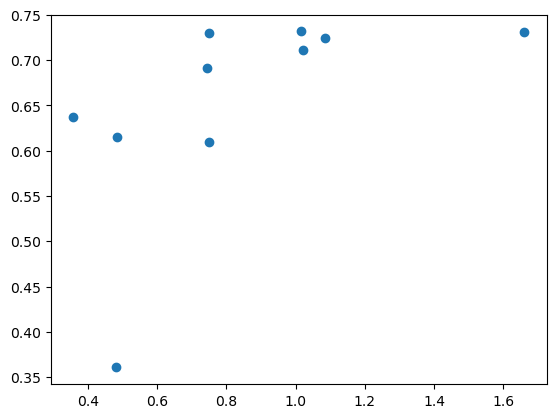

In [10]:
plt.scatter(true_zs,pred_zs)

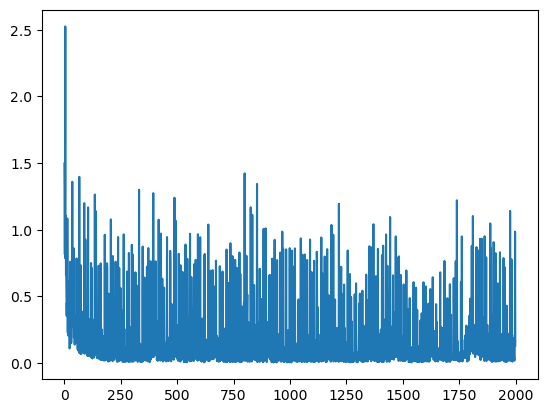

In [16]:
plt.plot(trainer.lossList)

In [11]:
pred_zs

[array([0.637445], dtype=float32),
 array([0.72964054], dtype=float32),
 array([0.73150456], dtype=float32),
 array([0.73177373], dtype=float32),
 array([0.36057785], dtype=float32),
 array([0.69153553], dtype=float32),
 array([0.6148764], dtype=float32),
 array([0.72454613], dtype=float32),
 array([0.7108696], dtype=float32),
 array([0.6099255], dtype=float32)]

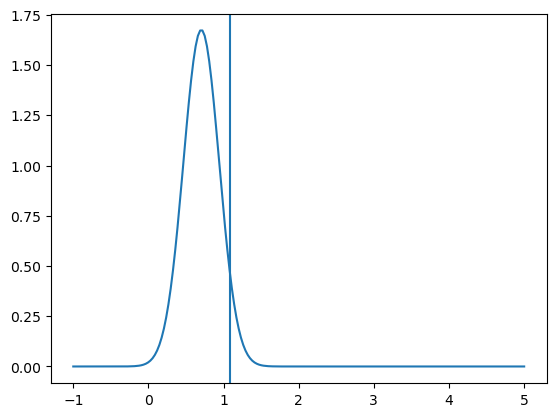

In [23]:
i=7
plt.plot(zs,pred_pdfs[i])
plt.axvline(true_zs[i])
#plt.plot(zs,pred_pdfs[i+3])


In [7]:
cfg = LazyConfig.load(cfgfile)


In [9]:
print(cfg.optimizer)

{'params': {'weight_decay_norm': 0.0, '_target_': <function get_default_optimizer_params at 0x7ffdf8307280>}, 'lr': 0.02, 'momentum': 0.9, 'weight_decay': 0.0001, '_target_': <class 'torch.optim.sgd.SGD'>}


In [24]:
pred_pdfs

[array([1.25993261e-11, 3.09459160e-11, 7.47982232e-11, 1.77914086e-10,
        4.16448459e-10, 9.59277102e-10, 2.17449725e-09, 4.85070339e-09,
        1.06483533e-08, 2.30033610e-08, 4.89026100e-08, 1.02306849e-07,
        2.10624492e-07, 4.26721499e-07, 8.50769027e-07, 1.66920904e-06,
        3.22285882e-06, 6.12355097e-06, 1.14497843e-05, 2.10679755e-05,
        3.81487371e-05, 6.79780351e-05, 1.19203498e-04, 2.05703313e-04,
        3.49320966e-04, 5.83767542e-04, 9.60034668e-04, 1.55369367e-03,
        2.47443235e-03, 3.87808448e-03, 5.98123204e-03, 9.07811616e-03,
        1.35591459e-02, 1.99296940e-02, 2.88270786e-02, 4.10328917e-02,
        5.74771613e-02, 7.92300850e-02, 1.07477240e-01, 1.43474445e-01,
        1.88479543e-01, 2.43660733e-01, 3.09983432e-01, 3.88081610e-01,
        4.78122562e-01, 5.79678357e-01, 6.91618383e-01, 8.12040329e-01,
        9.38253760e-01, 1.06682861e+00, 1.19371486e+00, 1.31443226e+00,
        1.42431951e+00, 1.51882696e+00, 1.59382546e+00, 1.645905